## Foundations of Data Science: Inferential Thinking by Resampling

Mirroring course Jupyter notebook except using standard modules instead of Berkeley data science module.

## Lecture 7: Decisions and uncertainty

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

plt.style.use('fivethirtyeight')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('max_columns', 50)
pd.set_option('max_rows', 9)

### Data Exploration

In [2]:
baby = pd.read_csv('data/baby.csv')
baby

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
...,...,...,...,...,...,...
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False
1173,117,297,38,65,129,False


In [3]:
baby['Maternal Smoker'].value_counts()

False    715
True     459
Name: Maternal Smoker, dtype: int64

In [4]:
pd.pivot_table(baby, index='Maternal Smoker')

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight
Maternal Smoker,,,,,
False,123.09,279.87,27.54,64.01,129.48
True,113.82,277.90,26.74,64.10,126.92


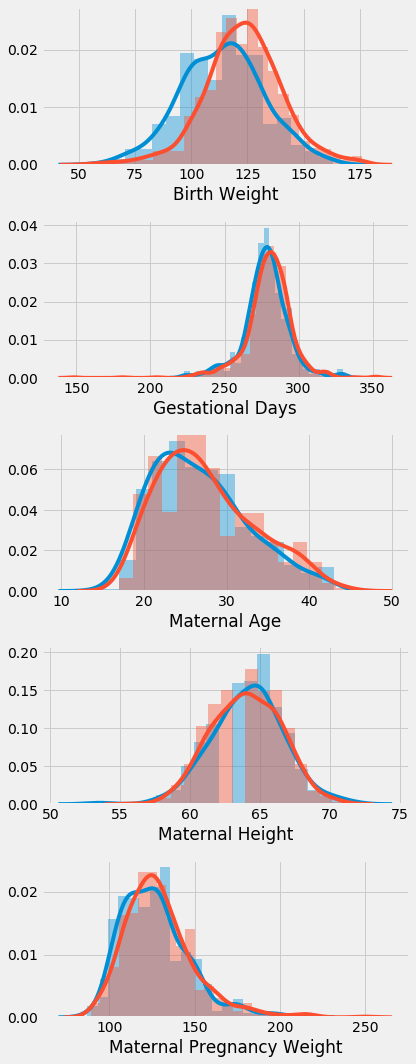

In [5]:
cols = baby.drop('Maternal Smoker', axis=1).columns
fig, axarr = plt.subplots(len(cols), 1, figsize=(6, len(cols)*3))

for idx, col in enumerate(cols):
    sns.distplot(baby.loc[baby['Maternal Smoker'] == True][col],
                  hist=True, ax=axarr[idx])
    sns.distplot(baby.loc[baby['Maternal Smoker'] == False][col],
                  hist=True, ax=axarr[idx])
    
plt.tight_layout()
plt.show()

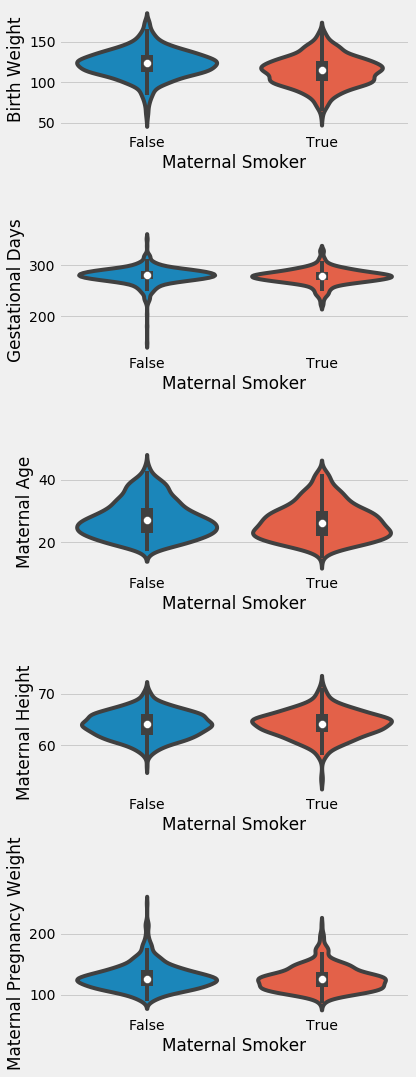

In [6]:
cols = baby.drop('Maternal Smoker', axis=1).columns
fig, axarr = plt.subplots(len(cols), 1, figsize=(6, len(cols)*3))

for idx, col in enumerate(cols):
    sns.violinplot(x='Maternal Smoker', y=col, data=baby, ax=axarr[idx])

plt.tight_layout()
plt.show()

### Hypothesis testing and Confidence intervals

In [7]:
def cohen_d(x, y):
    ''' Returns Cohen's d for two data sets'''
    n_x = len(x)
    x_bar = np.mean(x)
    s_x = np.std(x, ddof=1)
    n_y = len(y)
    y_bar = np.mean(y)
    s_y = np.std(y, ddof=1)

    s_pooled = np.sqrt((((n_x - 1) * s_x ** 2) +
                        ((n_y - 1) * s_y ** 2)) / (n_x + n_y - 2))
    cohen_d = np.abs(x_bar - y_bar) / s_pooled

    return cohen_d

In [8]:
def ci_diff(x, y, cl=0.95, eqvar=False):
    ''' Returns the confidence interval for the difference of two data sets '''
    n_x = len(x)
    x_bar = np.mean(x)
    s_x = np.std(x, ddof=1)
    n_y = len(y)
    y_bar = np.mean(y)
    s_y = np.std(y, ddof=1)
    
    # Difference in means
    diff_bar = x_bar - y_bar
  
    # dof - if population variences are equal
    if eqvar:
        dof = n_x + n_y - 2
        std_diff = np.sqrt(((n_x - 1) * (s_x) ** 2 +
                            (n_y - 1) * (s_y) ** 2) / 
                           dof * ((1 / n_x) + (1 / n_y)))
        
    else:
        dof = ((s_x ** 2 / n_x + s_y ** 2 / n_y) ** 2 / 
               (1 / (n_x - 1) * (s_x ** 2 / n_x) ** 2 + 
                1 / (n_y - 1) * (s_y ** 2 / n_y) ** 2))
        std_diff = np.sqrt(s_x ** 2 / (n_x) + s_y ** 2 / (n_y))
        
    # t-score
    alpha = 1 - cl
    t_score = (stats.t.ppf((1 - (alpha / 2)), dof)) 
    
    # Error bound of the mean  
    ebm = t_score * std_diff 
    

    return (diff_bar - ebm, diff_bar + ebm)

In [9]:
# Alternatively could use statsmodels
#import statsmodels.stats.api as sms
#cm = sms.CompareMeans(sms.DescrStatsW(smoker), sms.DescrStatsW(nonsmoker))
#cm.tconfint_diff(0.05, usevar='unequal')

In [10]:
for col in baby.drop('Maternal Smoker', axis=1).columns:
    smoker = baby.loc[baby['Maternal Smoker'] == True][col]
    nonsmoker = baby.loc[baby['Maternal Smoker'] == False][col]
    print('{0}:'.format(col))
    print(' p-value   = {0:.3f}'.format(stats.ttest_ind(smoker, nonsmoker, 
                                               equal_var=False)[1]))
    print(" Cohen's d = {0:.3f}".format(cohen_d(smoker, nonsmoker)))
    ci_low, ci_high = ci_diff(smoker, nonsmoker)
    print(" 95% CI of difference (smoker - nonsmoker) = ({0:.2f}, {1:.2f})".
          format(ci_low, ci_high))
    print()

Birth Weight:
 p-value   = 0.000
 Cohen's d = 0.521
 95% CI of difference (smoker - nonsmoker) = (-11.37, -7.16)

Gestational Days:
 p-value   = 0.036
 Cohen's d = 0.124
 95% CI of difference (smoker - nonsmoker) = (-3.82, -0.13)

Maternal Age:
 p-value   = 0.020
 Cohen's d = 0.139
 95% CI of difference (smoker - nonsmoker) = (-1.49, -0.13)

Maternal Height:
 p-value   = 0.553
 Cohen's d = 0.036
 95% CI of difference (smoker - nonsmoker) = (-0.21, 0.39)

Maternal Pregnancy Weight:
 p-value   = 0.037
 Cohen's d = 0.124
 95% CI of difference (smoker - nonsmoker) = (-4.96, -0.16)



##### Maternal Smoker - t-test results
* Baby info 
  + 'Birth Weight' has the strongest significance and a moderate effect size.
  + 'Gestational Days' also has a significant p-value, but with a small effect size
<br><br>
* Mother info
  + 'Maternal Age' and 'Maternal Pregnancy Weight' also have significant p-values
     with small effect sizes
  +  Analysis might benefit from stratification 
  + 'Maternal Height' is not significantly correlated with smoking

### Using Simulation

#### For Birth Weight

In [13]:
sim_baby = baby[['Birth Weight', 'Maternal Smoker']]

,Birth Weight,Maternal Smoker
0,120,False
1,113,False
2,128,True
3,108,True
...,...,...
1170,128,False
1171,130,True
1172,125,False
1173,117,False


In [35]:
sim_diffs = []
for _ in range(5000):
    np.random.shuffle(sim_baby['Maternal Smoker'].values)
    smoker = sim_baby.loc[sim_baby['Maternal Smoker'] == True]['Birth Weight']
    nonsmoker = sim_baby.loc[sim_baby['Maternal Smoker'] == False]['Birth Weight']
    sim_diffs.append(smoker.mean() - nonsmoker.mean())
    

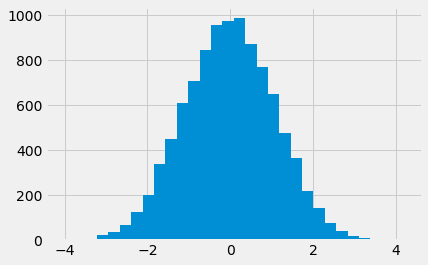

In [36]:
plt.hist(sim_diffs, bins=30)
plt.show()


In [37]:
smoker = baby.loc[baby['Maternal Smoker'] == True]['Birth Weight']
nonsmoker = baby.loc[baby['Maternal Smoker'] == False]['Birth Weight']
smoker.mean() - nonsmoker.mean()

-9.266142572024918

#### For Gestational Days

In [39]:
sim_baby = baby[['Gestational Days', 'Maternal Smoker']]

In [40]:
sim_diffs = []
for _ in range(5000):
    np.random.shuffle(sim_baby['Maternal Smoker'].values)
    # Could alternatively use pandas sample method
    smoker = sim_baby.loc[sim_baby['Maternal Smoker'] == True]['Gestational Days']
    nonsmoker = sim_baby.loc[sim_baby['Maternal Smoker'] == False]['Gestational Days']
    sim_diffs.append(smoker.mean() - nonsmoker.mean())

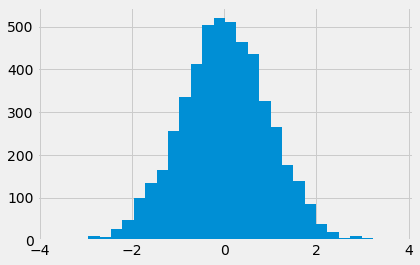

In [41]:
plt.hist(sim_diffs, bins=30)
plt.show()

In [42]:
smoker = baby.loc[baby['Maternal Smoker'] == True]['Gestational Days']
nonsmoker = baby.loc[baby['Maternal Smoker'] == False]['Gestational Days']
smoker.mean() - nonsmoker.mean()

-1.9765223882870941